In [1]:
import torch
import torch.nn as nn
from lib2to3.pgen2 import token
from tracemalloc import start
import numpy as np
import csv
import keras
from sklearn.utils import shuffle 
import time as tt
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(1)
device = 'cuda'
torch.set_default_tensor_type('torch.cuda.FloatTensor')

def runtime(starttime):
    ret = tt.time() - starttime
    return ret

def unison_shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_pretrained_embeddings(filepath):
    print("Loading in pretrained GloVe embeddings from: {}".format(filepath))
    
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as embedfile:
        for line in embedfile:
            split_line = line.split()
            token = split_line[0]
            embed = np.array(split_line[1:], dtype=np.float64)
            embeddings[token] = embed
    
    print("{} words loaded into embedding".format(len(embeddings)))
    
    return (embeddings)

def tokenize_csv(filename):
    sen=[]
    lab=[]

    with open(filename, mode='r',encoding='utf-8') as csvfile:
        tweetreader = csv.reader(csvfile)
        firstline=True
        for sentence, label in tweetreader:
            if firstline:
                firstline=False
                continue
            else:
                sen.append(keras.preprocessing.text.text_to_word_sequence(sentence.encode('ascii', 'ignore').decode('ascii')))
                if label=='sadness':
                    lab.append([0,0,0,0,1])
                elif label=='happiness':
                    lab.append([0,0,0,1,0])
                elif label=='no emotion':
                    lab.append([0,0,1,0,0])
                elif label=='fear':
                    lab.append([0,1,0,0,0])
                else:
                    lab.append([1,0,0,0,0])

    return (sen, lab)

def tokenize_manual(filename, label):
    '''
        00001 sadness 
        00010 happiness
        00100 no emotion
        01000 fear
        10000 anger
    '''

    sen=[]
    lab=[]
    with open(filename, mode='r', encoding='utf-8') as csvfile:
        treader=csv.reader(csvfile)
        firstline=True
        for i_d, t in treader:
            if firstline:
                firstline=False
                continue
            else:
                sen.append(keras.preprocessing.text.text_to_word_sequence(t.encode('ascii', 'ignore').decode('ascii')))
                lab.append(label)
    
    return (sen, lab)

def tweet_vectorize(tweet_label_in, glove_embeds):
    out_vectors = []

    tweet_list = tweet_label_in[0]
    label_list = tweet_label_in[1]

    for i in range(len(tweet_list)):
        curr_tweet = []
        while len(tweet_list[i]) > 0 and len(curr_tweet) < 50:
            curr_word = tweet_list[i].pop(0)
            if curr_word in glove_embeds:
                curr_tweet.append(glove_embeds[curr_word])
            else:
                curr_tweet.append(np.zeros(50))     # dimensionality of embedding vector
        if len(curr_tweet) < 50:
            while len(curr_tweet) < 50:
                curr_tweet.append(np.zeros(50))
        out_vectors.append(curr_tweet)
    
    return (out_vectors, label_list)

def split_train_val_test(input, labels, man_input, man_lab):

  input_shuff, labels_shuff = shuffle(input, labels)

  training_proportion = 0.8
  validation_proportion = 0.1
  num_train = int(len(input_shuff) * training_proportion)
  num_val = int(len(input_shuff) * validation_proportion)

  input_train, input_valid, input_test = input_shuff[:num_train], input_shuff[num_train:num_train+num_val], input_shuff[num_train+num_val:]
  label_train, label_valid, label_test = labels_shuff[:num_train], labels_shuff[num_train:num_train+num_val], labels_shuff[num_train+num_val:]

  input_test += man_input
  label_test += man_lab

  return input_train, input_valid, input_test, label_train, label_valid, label_test

def convert_to_tensors(input_train, input_valid, input_test, label_train, label_valid, label_test):
  input_train = torch.as_tensor(input_train)
  input_valid = torch.as_tensor(input_valid)
  input_test = torch.as_tensor(input_test)
  label_train = torch.as_tensor(label_train)
  label_valid = torch.as_tensor(label_valid)
  label_test = torch.as_tensor(label_test)

  return input_train, input_valid, input_test, label_train, label_valid, label_test

def accuracy_calc(predictions, labels):
    prediction = torch.argmax(predictions, dim=1)
    prediction = nn.functional.one_hot(prediction, num_classes=5)
    ret = torch.unique(prediction[prediction == labels], return_counts=True)
    if ret[0][-1] == 1: ret = float(ret[1][1]/len(labels))
    else: ret = 0.0
    return ret

# Model Definition
class model(nn.Module):
    def __init__(self, in_channels=50, out_channels=50, kernel_size=3, stride=1, hidden_dim=4, num_layers=1):
        super(model, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.convolution_layer1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride),      # IN: [batch_size, num_vecs=50, embed_dim=50], OUT: [batch_size, out_channel=50, convolved=48]
            nn.BatchNorm1d(out_channels),                                   # unchanged; in-place op
            nn.ReLU(),                                                      # unchanged; in-place ops
            nn.MaxPool1d(kernel_size))                                      # IN: [batch_size, out_channel=50, convolved=48], OUT: [batch_size, 50, floor(convolved/kernel_size)=16]

        self.bilstm = nn.LSTM(input_size=int((self.in_channels - self.kernel_size + 1)/self.kernel_size), hidden_size=hidden_dim, bidirectional=True, num_layers=num_layers)   # IN: [batch_size, 50, 16], OUT: [batch_size, 50, 8]

        self.lin1 = nn.Linear(out_channels, 1)
        self.lin2 = nn.Linear(8, 5)     # whatever the 2nd of bilstm out is

        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        x = self.convolution_layer1(x)
        x, (hn, cn) = self.bilstm(x)
        x = torch.transpose(x, 1, 2)
        x = self.lin1(x)
        x = torch.transpose(x, 1, 2)
        x = self.lin2(x)
        x = self.softmax(x)
        return(x)

# training loop
def training_loop(model_instance, loss, optimizer, epochs, batch_size, x_train, y_train):
  for epoch in range(epochs):
    prediction = model_instance(x_train)
    print(prediction.shape)
    loss_value = loss(prediction, y_train)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()


In [3]:
runstart = tt.time()
small_embeds = load_pretrained_embeddings("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/glove.6B/glove.6B.50d.txt")

Loading in pretrained GloVe embeddings from: D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/glove.6B/glove.6B.50d.txt
400000 words loaded into embedding


In [4]:
training_set = [[], []]
for i in range(1, 6):
    train_tokens = tokenize_csv("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/tweet_emotion/tweets_labels/data{}.csv".format(str(i)))
    temp_vec = tweet_vectorize(train_tokens, small_embeds)
    training_set[0] = training_set[0] + temp_vec[0]
    training_set[1] = training_set[1] + temp_vec[1]
    print('Finished vectorizing csv number {}'.format(str(i)), "Dataset size: ", len(training_set[0]), len(training_set[1]))

manual_names = ['anger', 'fear', 'happy', 'sad']
manual_labels = [[1,0,0,0,0], [0,1,0,0,0], [0,0,0,1,0], [0,0,0,0,1]]

manual_set = [[], []]
for i in range(len(manual_labels)):
    manual_tokens = tokenize_manual("D:/OneDrive - University of Toronto/School/NSCI Y3/WINTER/ECE324/tweet_emotion/manually_labeled/data_{}.csv".format(manual_names[i]), manual_labels[i])
    temp_vec = tweet_vectorize(manual_tokens, small_embeds)
    manual_set[0] = manual_set[0] + temp_vec[0]
    manual_set[1] = manual_set[1] + temp_vec[1]

Finished vectorizing csv number 1 Dataset size:  28091 28091
Finished vectorizing csv number 2 Dataset size:  65180 65180
Finished vectorizing csv number 3 Dataset size:  104505 104505
Finished vectorizing csv number 4 Dataset size:  143588 143588
Finished vectorizing csv number 5 Dataset size:  207863 207863


In [5]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_train_val_test(training_set[0], training_set[1], manual_set[0], manual_set[1])
x_train, x_valid, x_test, y_train, y_valid, y_test = convert_to_tensors(x_train, x_valid, x_test, y_train, y_valid, y_test)

C:\Users\garyx\AppData\Local\Temp/ipykernel_22636/1591375611.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_train = torch.as_tensor(input_train)


#### Initial tested parameters
Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 30, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train & Valid accuracy w/ params: 60.4906% & 60.3420%

#### Tuning tested parameters
Training params: epochs = 10, learning rate = 0.0001, batch size = 5000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 30, kernel_size = 5, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy w/ params: 60.0988, 60.2081, 59.4562

Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 60.5603%, 60.5773%, 60.395527%

Training params: epochs = 10, learning rate = 0.001, batch size = 10000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 2 <br/>
Train Valid Test accuracy accuracy w/ params: 60.0768%, 60.0725%, 59.479868%

Training params: epochs = 100, learning rate = 0.001, batch size = 1000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 69.5821%, 66.4842%, 65.8611% |||| Took ~24 min

Training params: epochs = 50, learning rate = 0.001, batch size = 1000, optimizer = Adam, loss = BCELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 68.7802%, 65.6326%, 65.2617% |||| Took ~12 min

Training params: epochs = 50, learning rate = 0.001, batch size = 1000, optimizer = Adam, loss = CELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 68.44% |||| Took ~15 min

Training params: epochs = 50, learning rate = 0.001, batch size = 500, optimizer = Adam, loss = CELoss <br/>
Model params: out_channels = 50, kernel_size = 3, stride = 1, hidden_dim = 4, num_layers = 1 <br/>
Train Valid Test accuracy accuracy w/ params: 69.20% 65.77% 65.39% |||| Took ~15 min

In [6]:
start = tt.time()

y_train = torch.squeeze(y_train, dim=1)
y_valid = torch.squeeze(y_valid, dim=1)
y_test = torch.squeeze(y_test, dim=1)

model_instance = model()

# Training hyperparams
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_instance.parameters(), lr=0.001)
batch_size = 500
num_epochs = 50

epoch_acc = []
epoch_loss = []

curr_iter = 0
for epoch in tqdm(range(int(num_epochs)), desc='Training Epochs'):
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    for b in range(0, len(x_train), batch_size):
        x_batch = x_train[b:b+batch_size]
        y_batch = y_train[b:b+batch_size]

        prediction = model_instance(x_batch)
        prediction = torch.squeeze(prediction, dim=1)
        y_batch = y_batch.type(torch.cuda.FloatTensor)
        loss_value = loss(prediction, y_batch)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_acc.append(accuracy_calc(prediction, y_batch))
        train_loss.append(loss_value.item())
        
    train_loss = np.asarray(train_loss)
    train_acc = np.asarray(train_acc)
    epoch_loss.append(np.mean(train_loss))
    epoch_acc.append(100*np.mean(train_acc))

    for b in range(0, len(x_valid), batch_size):
        x_batch = x_valid[b:b+batch_size]
        y_batch = y_valid[b:b+batch_size]

        prediction = model_instance(x_batch)
        prediction = torch.squeeze(prediction, dim=1)
        y_batch = y_batch.type(torch.cuda.FloatTensor)
        loss_value = loss(prediction, y_batch)

        valid_acc.append(accuracy_calc(prediction, y_batch))
        valid_loss.append(loss_value.item())

    valid_loss = np.asarray(valid_loss)
    valid_acc = np.asarray(valid_acc)
    
    print("Train Loss: {:.4f}\t\t".format(epoch_loss[-1])) 
    print("Train Acc: {:.4f}%\t".format(epoch_acc[-1]))
    print("Valid Loss: {:.4f}\t\t".format(np.mean(valid_loss))) 
    print("Valid Acc: {:.4f}%\t".format(100*np.mean(valid_acc)))

print("Total training runtime: {:2f}".format(runtime(start)))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\garyx\AppData\Local\Temp/ipykernel_22636/1591375611.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Training Epochs:   2%|▏         | 1/50 [00:20<16:53, 20.68s/it]

Train Loss: 1.3343		
Train Acc: 59.6084%	
Valid Loss: 1.3010		
Valid Acc: 60.3998%	


Training Epochs:   4%|▍         | 2/50 [00:40<15:57, 19.94s/it]

Train Loss: 1.3041		
Train Acc: 60.0823%	
Valid Loss: 1.3009		
Valid Acc: 60.3998%	


Training Epochs:   6%|▌         | 3/50 [00:59<15:22, 19.62s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3009		
Valid Acc: 60.3998%	


Training Epochs:   8%|▊         | 4/50 [01:18<14:48, 19.32s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  10%|█         | 5/50 [01:37<14:21, 19.15s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  12%|█▏        | 6/50 [01:56<14:00, 19.09s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  14%|█▍        | 7/50 [02:15<13:39, 19.06s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  16%|█▌        | 8/50 [02:34<13:21, 19.07s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  18%|█▊        | 9/50 [02:53<13:04, 19.13s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  20%|██        | 10/50 [03:12<12:45, 19.14s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  22%|██▏       | 11/50 [03:31<12:22, 19.04s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  24%|██▍       | 12/50 [03:49<11:57, 18.89s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  26%|██▌       | 13/50 [04:08<11:35, 18.80s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  28%|██▊       | 14/50 [04:27<11:15, 18.75s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  30%|███       | 15/50 [04:45<10:55, 18.74s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  32%|███▏      | 16/50 [05:04<10:35, 18.70s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  34%|███▍      | 17/50 [05:23<10:16, 18.68s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  36%|███▌      | 18/50 [05:41<09:56, 18.64s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  38%|███▊      | 19/50 [06:00<09:40, 18.72s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  40%|████      | 20/50 [06:19<09:20, 18.67s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  42%|████▏     | 21/50 [06:37<09:00, 18.65s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  44%|████▍     | 22/50 [06:56<08:41, 18.64s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  46%|████▌     | 23/50 [07:14<08:23, 18.64s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  48%|████▊     | 24/50 [07:33<08:05, 18.67s/it]

Train Loss: 1.3040		
Train Acc: 60.0823%	
Valid Loss: 1.3008		
Valid Acc: 60.3998%	


Training Epochs:  50%|█████     | 25/50 [07:51<07:39, 18.40s/it]

Train Loss: 1.2803		
Train Acc: 62.0641%	
Valid Loss: 1.2577		
Valid Acc: 64.1747%	


Training Epochs:  52%|█████▏    | 26/50 [08:07<07:04, 17.69s/it]

Train Loss: 1.2551		
Train Acc: 64.4707%	
Valid Loss: 1.2511		
Valid Acc: 64.9294%	


Training Epochs:  54%|█████▍    | 27/50 [08:24<06:42, 17.52s/it]

Train Loss: 1.2483		
Train Acc: 65.2585%	
Valid Loss: 1.2486		
Valid Acc: 65.1258%	


Training Epochs:  56%|█████▌    | 28/50 [08:43<06:35, 18.00s/it]

Train Loss: 1.2435		
Train Acc: 65.7601%	
Valid Loss: 1.2472		
Valid Acc: 65.1223%	


Training Epochs:  58%|█████▊    | 29/50 [09:01<06:15, 17.87s/it]

Train Loss: 1.2397		
Train Acc: 66.1938%	
Valid Loss: 1.2467		
Valid Acc: 65.2044%	


Training Epochs:  60%|██████    | 30/50 [09:18<05:50, 17.53s/it]

Train Loss: 1.2365		
Train Acc: 66.5444%	
Valid Loss: 1.2459		
Valid Acc: 65.3485%	


Training Epochs:  62%|██████▏   | 31/50 [09:35<05:30, 17.39s/it]

Train Loss: 1.2340		
Train Acc: 66.8531%	
Valid Loss: 1.2453		
Valid Acc: 65.4651%	


Training Epochs:  64%|██████▍   | 32/50 [09:54<05:22, 17.94s/it]

Train Loss: 1.2322		
Train Acc: 67.0679%	
Valid Loss: 1.2448		
Valid Acc: 65.4068%	


Training Epochs:  66%|██████▌   | 33/50 [10:13<05:12, 18.36s/it]

Train Loss: 1.2309		
Train Acc: 67.1869%	
Valid Loss: 1.2440		
Valid Acc: 65.5235%	


Training Epochs:  68%|██████▊   | 34/50 [10:33<04:58, 18.68s/it]

Train Loss: 1.2296		
Train Acc: 67.2740%	
Valid Loss: 1.2428		
Valid Acc: 65.6235%	


Training Epochs:  70%|███████   | 35/50 [10:52<04:43, 18.91s/it]

Train Loss: 1.2287		
Train Acc: 67.3596%	
Valid Loss: 1.2423		
Valid Acc: 65.7009%	


Training Epochs:  72%|███████▏  | 36/50 [11:11<04:26, 19.02s/it]

Train Loss: 1.2266		
Train Acc: 67.6445%	
Valid Loss: 1.2421		
Valid Acc: 65.8140%	


Training Epochs:  74%|███████▍  | 37/50 [11:30<04:05, 18.86s/it]

Train Loss: 1.2247		
Train Acc: 67.8814%	
Valid Loss: 1.2422		
Valid Acc: 65.7830%	


Training Epochs:  76%|███████▌  | 38/50 [11:48<03:42, 18.52s/it]

Train Loss: 1.2230		
Train Acc: 68.0936%	
Valid Loss: 1.2425		
Valid Acc: 65.6771%	


Training Epochs:  78%|███████▊  | 39/50 [12:06<03:24, 18.57s/it]

Train Loss: 1.2215		
Train Acc: 68.2640%	
Valid Loss: 1.2429		
Valid Acc: 65.5985%	


Training Epochs:  80%|████████  | 40/50 [12:25<03:06, 18.69s/it]

Train Loss: 1.2205		
Train Acc: 68.3708%	
Valid Loss: 1.2432		
Valid Acc: 65.5497%	


Training Epochs:  82%|████████▏ | 41/50 [12:44<02:49, 18.82s/it]

Train Loss: 1.2209		
Train Acc: 68.2391%	
Valid Loss: 1.2424		
Valid Acc: 65.6306%	


Training Epochs:  84%|████████▍ | 42/50 [13:03<02:30, 18.84s/it]

Train Loss: 1.2213		
Train Acc: 68.1319%	
Valid Loss: 1.2432		
Valid Acc: 65.6509%	


Training Epochs:  86%|████████▌ | 43/50 [13:22<02:11, 18.84s/it]

Train Loss: 1.2202		
Train Acc: 68.3074%	
Valid Loss: 1.2422		
Valid Acc: 65.6675%	


Training Epochs:  88%|████████▊ | 44/50 [13:41<01:53, 18.89s/it]

Train Loss: 1.2183		
Train Acc: 68.5144%	
Valid Loss: 1.2419		
Valid Acc: 65.7485%	


Training Epochs:  90%|█████████ | 45/50 [14:00<01:34, 18.90s/it]

Train Loss: 1.2167		
Train Acc: 68.7567%	
Valid Loss: 1.2419		
Valid Acc: 65.7032%	


Training Epochs:  92%|█████████▏| 46/50 [14:19<01:15, 18.90s/it]

Train Loss: 1.2153		
Train Acc: 68.9467%	
Valid Loss: 1.2417		
Valid Acc: 65.8437%	


Training Epochs:  94%|█████████▍| 47/50 [14:38<00:56, 18.96s/it]

Train Loss: 1.2142		
Train Acc: 69.0419%	
Valid Loss: 1.2416		
Valid Acc: 65.8044%	


Training Epochs:  96%|█████████▌| 48/50 [14:57<00:37, 18.96s/it]

Train Loss: 1.2134		
Train Acc: 69.1514%	
Valid Loss: 1.2420		
Valid Acc: 65.8246%	


Training Epochs:  98%|█████████▊| 49/50 [15:16<00:18, 18.93s/it]

Train Loss: 1.2129		
Train Acc: 69.2047%	
Valid Loss: 1.2427		
Valid Acc: 65.7746%	


Training Epochs: 100%|██████████| 50/50 [15:35<00:00, 18.70s/it]

Train Loss: 1.2129		
Train Acc: 69.1489%	
Valid Loss: 1.2446		
Valid Acc: 65.5687%	
Total training runtime: 936.772631


In [7]:
# Test accuracy:
prediction = model_instance(x_test)
prediction = torch.squeeze(prediction, dim=1)
test_acc = accuracy_calc(prediction, y_test)
print("Test acc: {:4f}%".format(100*test_acc))

C:\Users\garyx\AppData\Local\Temp/ipykernel_22636/1591375611.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test acc: 65.389156%


Text(0.5, 1.0, 'Model Training Loss over 50 Epochs')

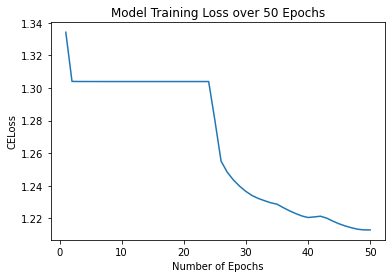

In [8]:
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('CELoss')
plt.title('Model Training Loss over 50 Epochs')

Text(0.5, 1.0, 'Model Training Accuracy over 50 Epochs')

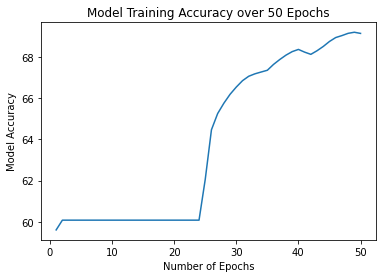

In [9]:
plt.plot(range(1, len(epoch_acc) + 1), epoch_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Model Accuracy')
plt.title('Model Training Accuracy over 50 Epochs')